# Implementing A Logistic Regression Model from Scratch with PyTorch

![alt text](https://drive.google.com/uc?export=view&id=11Bv3uhZtVgRVYVWDl9_ZAYQ0GU36LhM9)


In this tutorial, we are going to implement a logistic regression model from scratch with PyTorch. The model will be designed with neural networks in mind and will be used for a simple image classification task. I believe this is a great approach to begin understanding the fundamental building blocks behind a neural network. Additionally, we will also look at best practices on how to use PyTorch for training neural networks.

After completing this tutorial the learner is expected to know the basic building blocks of a logistic regression model. The learner is also expected to apply the logistic regression model to a binary image classification problem of their choice using PyTorch code.

---

**Author:** Elvis Saravia ( [Twitter](https://twitter.com/omarsar0) | [LinkedIn](https://www.linkedin.com/in/omarsar/))

**Complete Code Walkthrough:** [Blog post](https://medium.com/dair-ai/implementing-a-logistic-regression-model-from-scratch-with-pytorch-24ea062cd856?source=friends_link&sk=49dcddb17d1d021d2d677f3666c88463)

In [1]:
## Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


## Importing Dataset
In this tutorial we will be working on an image classification problem. You can find the public dataset [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip). 

The objective of our model is to learn to classify between "bee" vs. "no bee" images.

Uncomment the code below to download and unzip the data.

In [3]:
# download the data
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2022-06-17 23:55:52--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.67.65.73, 18.67.65.42, 18.67.65.118, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.67.65.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   152MB/s    in 0.3s    

2022-06-17 23:55:53 (152 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/

## Data Transformation
This is an image classification task, which means that we need to perform a few transformations on our dataset before we train our models. I used similar transformations as used in this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial). For a detailed overview of each transformation take a look at the official torchvision [documentation](https://pytorch.org/docs/stable/torchvision/transforms.html).

The following code block performs the following operations:
- The `data_transforms` contains a series of transformations that will be performed on each image found in the dataset. This includes cropping the image, resizing the image, converting it to tensor, reshaping it, and normalizing it. 
- Once those transformations have been defined, then the `DataLoader` function is used to automatically load the datasets and perform any additional configuration such as shuffling, batches, etc.

In [4]:
# configure root folder on your gdrive
data_dir = 'hymenoptera_data'

# custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)
        return result

# transformations used to standardize and normalize the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,)) # flattens the data
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,)) # flattens the data
    ]),
}

# load the correspoding folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# load the entire dataset; we are not using minibatches here
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],
                                            batch_size=len(image_datasets['train']),
                                            shuffle=True)

test_dataset = torch.utils.data.DataLoader(image_datasets['val'],
                                           batch_size=len(image_datasets['val']),
                                           shuffle=True)

In [5]:
len(image_datasets['train']), len(image_datasets['val'])

(244, 153)

## Print sample
It's always a good practise to take a quick look at the dataset before training your models. Below we print out an example of one of the images from the `train_dataset`.

Dimension of image: torch.Size([244, 150528]) 
 Dimension of labels torch.Size([244])


/home/codespace/.conda/envs/play/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  if __name__ == '__main__':


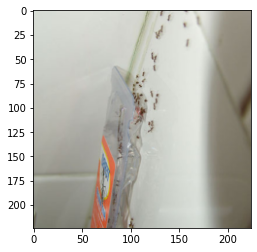

In [6]:
# load the entire dataset
x, y = next(iter(train_dataset))

# print one example
dim = x.shape[1]
print("Dimension of image:", x.shape, "\n", 
      "Dimension of labels", y.shape)

plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())

## Building the Model
Let's now implement our [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model. Logistic regression is one in a family of machine learning techniques that are used to train binary classifiers. They are also a great way to understand the fundamental building blocks of neural networks, thus they can also be considered the simplest of neural networks where the model performs a `forward` and `backward` propagation to train the model on the data provided. 

If you don't fully understand the structure of the code below, I strongly recommend you to read the following [tutorial](https://medium.com/dair-ai/pytorch-1-2-introduction-guide-f6fa9bb7597c), which I wrote for PyTorch beginners. You can also check out [Week 2](https://www.coursera.org/learn/neural-networks-deep-learning/home/week/2) of Andrew Ng's Deep Learning Specialization course for all the explanation, intuitions, and details of the different parts of the neural network such as the `forward`, `sigmoid`, `backward`, and `optimization` steps. 

In short:
- The `__init__` function initializes all the parameters (`W`, `b`, `grad`) that will be used to train the model through backpropagation. 
- The goal is to learn the `W` and `b` that minimimizes the cost function which is computed as seen in the `loss` function below.

Note that this is a very detailed implementation of a logistic regression model so I had to explicitly move a lot of the computations into the GPU for faster calcuation, `to(device)` takes care of this in PyTorch. 

In [7]:
class LR(nn.Module):
    def __init__(self, dim, lr=torch.scalar_tensor(0.01)):
        super(LR, self).__init__()
        # intialize parameters
        self.w = torch.zeros(dim, 1, dtype=torch.float).to(device)
        self.b = torch.scalar_tensor(0).to(device)
        self.grads = {"dw": torch.zeros(dim, 1, dtype=torch.float).to(device),
                      "db": torch.scalar_tensor(0).to(device)}
        self.lr = lr.to(device)

    def forward(self, x):
        # compute forward
        z = torch.mm(self.w.T, x) + self.b
        a = self.sigmoid(z)
        return a

    def sigmoid(self, z):
        # compute sigmoid
        return 1/(1 + torch.exp(-z))

    def backward(self, x, yhat, y):
        # compute backward
        self.grads["dw"] = (1/x.shape[1]) * torch.mm(x, (yhat - y).T)
        self.grads["db"] = (1/x.shape[1]) * torch.sum(yhat - y)
    
    def optimize(self):
        # optimization step
        self.w = self.w - self.lr * self.grads["dw"]
        self.b = self.b - self.lr * self.grads["db"]

## utility functions
def loss(yhat, y):
    m = y.size()[1]
    return -(1/m)* torch.sum(y*torch.log(yhat) + (1 - y)* torch.log(1-yhat))

def predict(yhat, y):
    y_prediction = torch.zeros(1, y.size()[1])
    for i in range(yhat.size()[1]):
        if yhat[0, i] <= 0.5:
            y_prediction[0, i] = 0
        else:
            y_prediction[0, i] = 1
    return 100 - torch.mean(torch.abs(y_prediction - y)) * 100

## Pretesting the Model
It is also good practice to test your model and make sure the right steps are taking place before training the entire model.

In [8]:
# model pretesting
x, y = next(iter(train_dataset))

# flatten/transform the data
x_flatten = x.T
y = y.unsqueeze(0) 

# num_px is the dimension of the images
dim = x_flatten.shape[0]

# model instance
model = LR(dim)
model.to(device)
yhat = model.forward(x_flatten.to(device))
yhat = yhat.data.cpu()

# calculate loss
cost = loss(yhat, y)
prediction = predict(yhat, y)
print("Cost: ", cost)
print("Accuracy: ", prediction)

# backpropagate
model.backward(x_flatten.to(device), yhat.to(device), y.to(device))
model.optimize()

Cost:  tensor(0.6931)
Accuracy:  tensor(50.4098)


## Train the Model
It's now time to train the model. 

In [9]:
# hyperparams
costs = []
dim = x_flatten.shape[0]
learning_rate = torch.scalar_tensor(0.0001).to(device)
num_iterations = 500
lrmodel = LR(dim, learning_rate)
lrmodel.to(device)

# transform the data
def transform_data(x, y):
    x_flatten = x.T
    y = y.unsqueeze(0) 
    return x_flatten, y 

# train the model
for i in range(num_iterations):
    x, y = next(iter(train_dataset))
    test_x, test_y = next(iter(test_dataset))
    x, y = transform_data(x, y)
    test_x, test_y = transform_data(test_x, test_y)

    # forward
    yhat = lrmodel.forward(x.to(device))
    cost = loss(yhat.data.cpu(), y)
    train_pred = predict(yhat, y)
        
    # backward
    lrmodel.backward(x.to(device), 
                    yhat.to(device), 
                    y.to(device))
    lrmodel.optimize()

    # test
    yhat_test = lrmodel.forward(test_x.to(device))
    test_pred = predict(yhat_test, test_y)

    if i % 10 == 0:
        costs.append(cost)

    if i % 10 == 0:
        print("Cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(i, 
                                                                                    cost, 
                                                                                    train_pred,
                                                                                    test_pred))

Cost after iteration 0: 0.6931472420692444 | Train Acc: 50.40983581542969 | Test Acc: 45.75163269042969
Cost after iteration 10: 0.6691470742225647 | Train Acc: 64.3442611694336 | Test Acc: 54.24836730957031
Cost after iteration 20: 0.6513182520866394 | Train Acc: 68.44261932373047 | Test Acc: 54.24836730957031
Cost after iteration 30: 0.6367825865745544 | Train Acc: 68.03278350830078 | Test Acc: 54.24836730957031
Cost after iteration 40: 0.6245337128639221 | Train Acc: 69.67213439941406 | Test Acc: 54.90196228027344
Cost after iteration 50: 0.6139225959777832 | Train Acc: 70.90164184570312 | Test Acc: 56.20914840698242
Cost after iteration 60: 0.6045235395431519 | Train Acc: 72.54098510742188 | Test Acc: 56.86274337768555
Cost after iteration 70: 0.5960511565208435 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
Cost after iteration 80: 0.5883085131645203 | Train Acc: 73.77049255371094 | Test Acc: 57.51633834838867
Cost after iteration 90: 0.5811557769775391 | Train Acc: 

## Result
From the loss curve below you can see that the model is sort of learning to classify the images given the decreas in the loss. I only ran the model for `100` iterations. Train the model for many more rounds and analyze the results. In fact, I have suggested a couple of experiments and exercises at the end of the tutorial that you can try to get a more improved model.

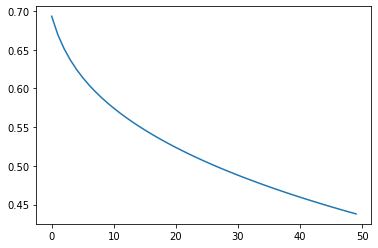

In [10]:
## the trend in the context of loss
plt.plot(costs)
plt.show()

## Some Notes
There are many improvements and different experiments that you can perform on top of this notebook to keep practising ML:
- It is always good to normalize/standardize your images which helps with learning. As an experiment, you can research and try different ways to standarize the dataset. We have normalized the dataset with the builtin PyTorch [normalizer](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) which uses the mean and standard deviation. Play around with different transformations or normalization techniques. What effect does this have on learning in terms of speed and loss?
- You can try many things to help with learning such as playing around with the learning rate. Try to decrease and increase the learning rate and observe the effect of this in learning? 
- If you explored the dataset further, you may have noticed that all the "no-bee" images are actually "ant" images. If you would like to create a more robust model, you may want to make your "no-bee" images more random and diverse through some data augmentation technique. This is a more advanced approach but there is a lot of good content to try out this idea. 
- The model is not really performing well just using simple logistic regression model. It could be because of the dataset I am using and because I didn't train it for long enough. Hyperparameters may also be off. It is a relatively small dataset but the performance could get better with more data and training over time. A more challenging task involves adopting the model to other datasets. Give it a try!
- Another important part that is missing in this tutorial is the comprehensive analysis of the model results. If you understand the code, it should be easy to figure out how to test with a few examples. In fact, it would also be great if you can put aside a small testing dataset for this part of the exercise, so as to test the generalization capabilities of the model.
- We built the logistic regression model from scratch but with libraries like PyTorch, these days you can simply leverage the high-level functions that implement certain parts of the neural network for you. This simplifies your code and minimizes the amount of bugs in your code. Plus you don't have to code your neural networks from scratch all the time. As a bonus exercise, try to adapt PyTorch builtin modules and functions for implementing a simpler, more concise version of the above logistic regression model. I will also add this as a to-do task for myself and post a solution soon. 

## References
- [Understanding the Impact of Learning Rate on Neural Network Performance](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)
- [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial)
- [Deep Learning Specialization by Andrew Ng](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome)